# Breast Cancer Analysis with Logistic Regression and RBF Network

In [30]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import rbf
import importlib
from math import sqrt

In [31]:
# Load the breast cancer dataset
data = load_breast_cancer()

# Convert to pandas DataFrame
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = (data.target == 0).astype(int)  # Binary target: 0 (malignant) -> 1, 1 (benign) -> 0

# Split the dataset into 70% training and 30% testing
X = df.drop(columns=['target'])
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Optionally, convert back to DataFrame after scaling
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

X_train.shape

(398, 30)

## Logistic regression on the original dataset

In [32]:
# Perform logistic regression
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)

# Compute the accuracy of the model
y_pred = logistic_regression.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.97


/Users/guilhermejose/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [33]:
# Compute the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f'True negatives: {tn}')
print(f'False positives: {fp}')
print(f'False negatives: {fn}')
print(f'True positives: {tp}')
print(f'Recall: {(tp / (tp + fn)):.2f}')


True negatives: 107
False positives: 1
False negatives: 4
True positives: 59
Recall: 0.94


In [34]:
# Perform Gaussian Mixture Model clustering, compute the silhouette score and store it
em_models = []
silhouettes = []
for k in range(2, 11):
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X_train)
    y_pred = gmm.predict(X_test)
    score = silhouette_score(X_test, y_pred)
    silhouettes.append(score)
    em_models.append(gmm)


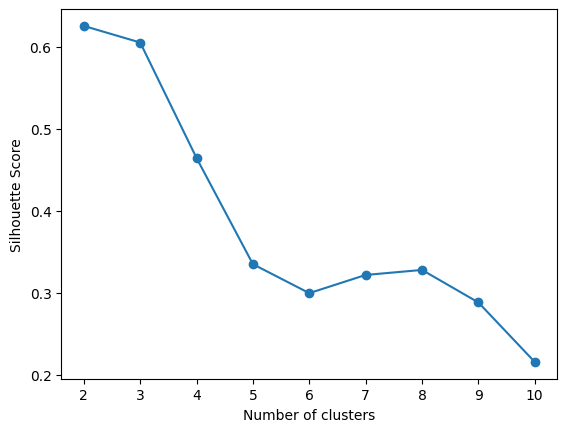

In [35]:
# Plot the silhouette results

plt.plot(range(2, 11), silhouettes, marker='o')

plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.show()

In [36]:
for i, score in enumerate(silhouettes):
    print(f'k = {i + 2}, Silhouette Score: {score:.2f}')

k = 2, Silhouette Score: 0.63
k = 3, Silhouette Score: 0.61
k = 4, Silhouette Score: 0.46
k = 5, Silhouette Score: 0.34
k = 6, Silhouette Score: 0.30
k = 7, Silhouette Score: 0.32
k = 8, Silhouette Score: 0.33
k = 9, Silhouette Score: 0.29
k = 10, Silhouette Score: 0.22


The number of clusters with the highest silhouette aligns perfectly with the problem. With a binary target variable we got k = 2 as the optimal number of clusters.

## Transforming the Data for Different k Values

In this step, we trasform the data into probability values for each cluster. We will make several transformations for different values of __k__. Then we store the transformed dataset to later use.

In [37]:
# For different k values, transform and store the data
X_train_transformed = []
X_test_transformed = []
for em_model in em_models:
    X_train_transformed.append(em_model.predict_proba(X_train))
    X_test_transformed.append(em_model.predict_proba(X_test))

Here we apply logistic regression for each of the transformed dataset and then store it.

## Classifying patients based on the cluster probabilities
Here, we use the cluster probabilities to classify the patients.

In [38]:
# Perform logistic regression on the transformed data
accuracies = []
recalls = []

# For different k values, apply logistic regression, compute and store the accuracy and confusion matrix
for i in range(len(em_models)):
    model = LogisticRegression()
    model.fit(X_train_transformed[i], y_train)
    y_pred = model.predict(X_test_transformed[i])
    score = accuracy_score(y_test, y_pred)
    accuracies.append(score)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    recall = tp / (tp + fn)
    recalls.append(recall)


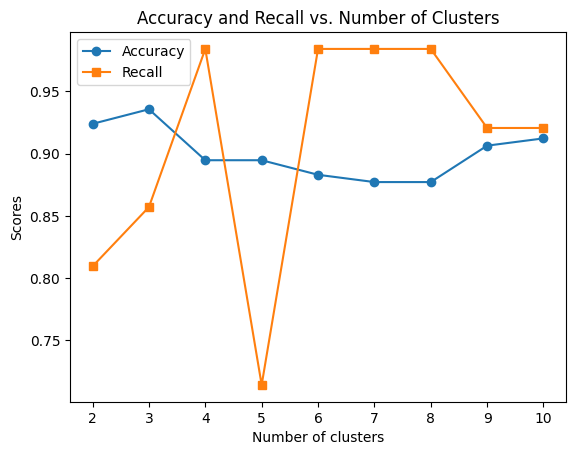

k = 2, Accuracy: 0.92, Recall: 0.81
k = 3, Accuracy: 0.94, Recall: 0.86
k = 4, Accuracy: 0.89, Recall: 0.98
k = 5, Accuracy: 0.89, Recall: 0.71
k = 6, Accuracy: 0.88, Recall: 0.98
k = 7, Accuracy: 0.88, Recall: 0.98
k = 8, Accuracy: 0.88, Recall: 0.98
k = 9, Accuracy: 0.91, Recall: 0.92
k = 10, Accuracy: 0.91, Recall: 0.92


In [39]:
# Plot accuracy and recall scores against the number of clusters
plt.plot(range(2, 11), accuracies, marker='o', label='Accuracy')
plt.plot(range(2, 11), recalls, marker='s', label='Recall')

# Add labels and legend
plt.xlabel('Number of clusters')
plt.ylabel('Scores')
plt.title('Accuracy and Recall vs. Number of Clusters')
plt.legend()

# Display the plot
plt.show()


for i in range(len(accuracies)):
    print(f'k = {i + 2}, Accuracy: {accuracies[i]:.2f}, Recall: {recalls[i]:.2f}')

## RBF network with mapped dataset when k = 2

In [40]:
# Get the centers of cluster 1 and 2
centers = em_models[0].means_

# Sigma is the euclidean distance between the centers of the two clusters multiplied by square root of 2
sigma = sqrt(2) * np.linalg.norm(centers[0] - centers[1])

# Reload the module to get the latest changes
importlib.reload(rbf)

# Initialize and fit the model
model = rbf.RBFNetwork(centers=centers, sigma=sigma)
model.fit(X_train, y_train)

In [41]:
# Predict the test data and compute the accuracy
importlib.reload(rbf)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9298245614035088

In [42]:
# Compute the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f'True negatives: {tn}')
print(f'False positives: {fp}')
print(f'False negatives: {fn}')
print(f'True positives: {tp}')
print(f'Recall: {(tp / (tp + fn)):.2f}')

True negatives: 108
False positives: 0
False negatives: 12
True positives: 51
Recall: 0.81


In [43]:
accuracies = []
recalls = []
for i, model in enumerate(em_models[1:]):
    centers = model.means_
    sigma = (np.mean([np.linalg.norm(centers[i] - centers[j]) for i in range(len(centers)) for j in range(i + 1, len(centers))])) 
    model = rbf.RBFNetwork(centers=centers, sigma=sigma)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    recall = tp / (tp + fn)
    recalls.append(recall)


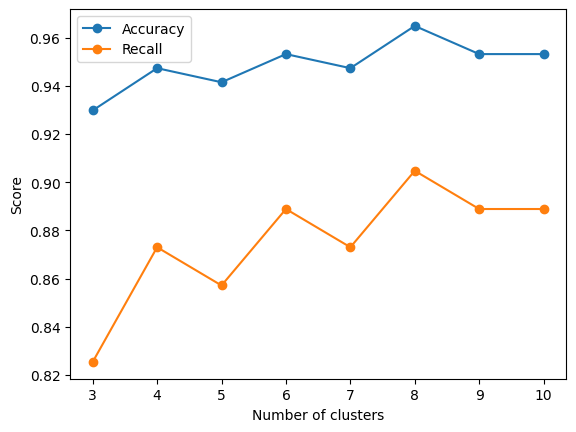

In [44]:
# Plot the recall and accuracy score against the number of clusters
plt.plot(range(3, 11), accuracies, marker='o', label='Accuracy')
plt.plot(range(3, 11), recalls, marker='o', label='Recall')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.legend()
plt.show()
